# Topic Modeling of Twitter Statuses with NMF

In [1]:
from gensim import corpora, models, similarities
from pymongo import MongoClient
import time
import os
import random
import numpy as np
import pyLDAvis.gensim
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings('ignore')

# Ugly hackery, but necessary: stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.append('../../')

from src.streaming import spark_functions

preprocess = spark_functions.preprocessor()
tokenize = spark_functions.tokenizer(remove_stopwords=True)

## Creating the Corpus and Dictionary

In [2]:
preprocess = spark_functions.preprocessor()
tokenize = spark_functions.tokenizer()

with open('./../../data/interim/stream_en.csv') as csv_file:
    iterator = csv.reader(csv_file, delimiter=',')
    # Load the tweets we need and preprocess as well as tokenize the text
    tweets = [" ".join(tokenize(preprocess(text))) for (_1, _2, _3, text) in iterator]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## Train the NMF model

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

In [5]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, 
 #         random_state=1, 
 #         alpha=.1, 
 #         l1_ratio=.5, 
 #         init='nndsvd'
         ).fit(tfidf)

## Some Experiments

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
mtvhottest lady gaga zara larsson
Topic 1:
love hot life prayers baby
Topic 2:
time right miss big trump
Topic 3:
need feel miss tell remember
Topic 4:
day august think stats morning
Topic 5:
people hate fucking world think
Topic 6:
video music youtube smtownglobal liked
Topic 7:
sex free girls girl porn
Topic 8:
follow win chance giveaway today
Topic 9:
look happy birthday mersal think


In [7]:
# nmf.components_: Factorization matrix, sometimes called ‘dictionary’.

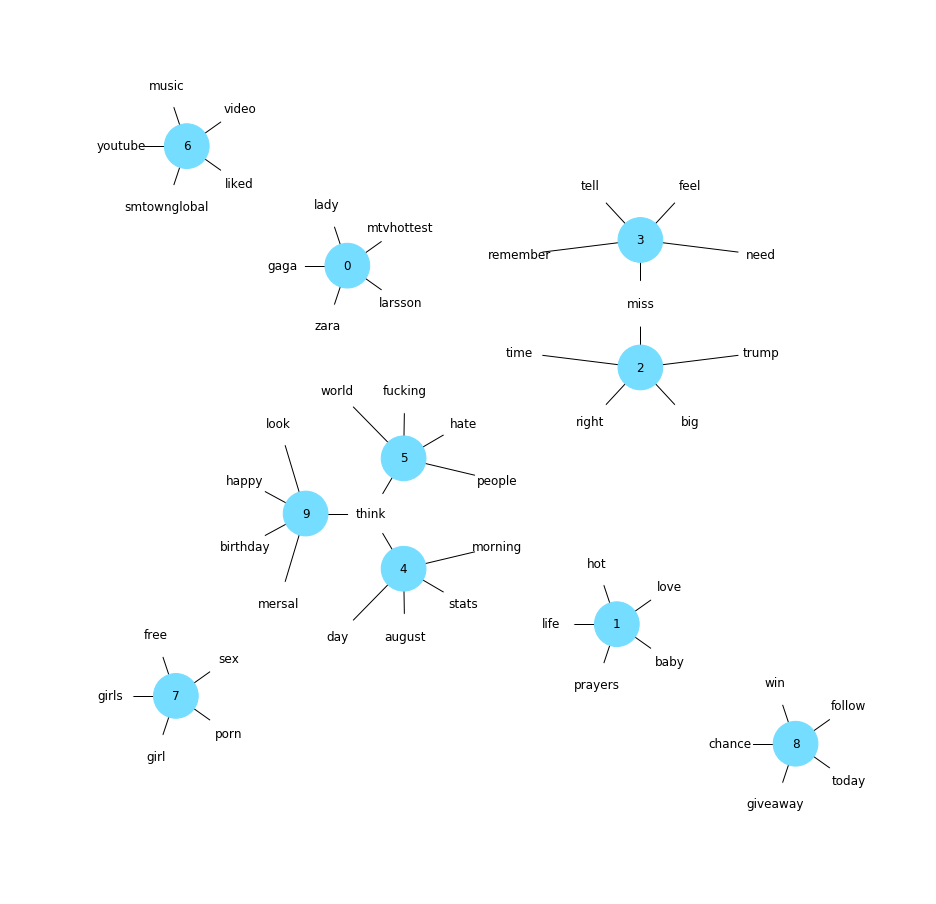

In [8]:
# TODO document
#brew install graphviz
#sudo pip install pygraphviz

graph = nx.Graph()
        
for topic_idx, topic in enumerate(nmf.components_):
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            graph.add_node(topic_idx,color="#75DDFF")
            graph.add_edge(topic_idx,tfidf_feature_names[i]) #,weight=term_probability*100

plt.figure(figsize=(16,16))

pos = graphviz_layout(graph, prog="twopi", root='1')
nodes = graph.nodes()

# nodes
nodes = graph.nodes(data=True)
colors = [node[1]['color'] if 'color' in node[1] else "#FFFFFF" for node in nodes]
nx.draw_networkx_nodes(graph,pos,node_color=colors, node_size=2000)

# edges
edges = graph.edges()
#weights = [graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(graph,pos,edgelist=edges) #,width=weights

# labels
sizes = [16 if 'color' in node[1] else 8 for node in nodes]
nx.draw_networkx_labels(graph,pos,font_size=12,font_family='sans-serif')

plt.axis('off')
plt.savefig('nmf_network_graph.pdf', format="pdf",bbox_inches='tight')
plt.show()